# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import es_core_news_sm

from collections import Counter
import itertools
from wordcloud import WordCloud

In [ ]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

# A - Exploración de datos y Procesamiento del Lenguaje Natural

Tanto el dataset de formación como el de prueba cuentan con <code>5000 reviews</code>, mientras que el de entrenamiento posee <code>200.000 instancias</code>

In [ ]:
print(df.shape)
print(df_test.shape)
print(df_train.shape)

Todos cuentan con 7 atributos:
- ID de reseña
- ID de producto
- ID de evaluador
- Estrellas
- Cuerpo de reseña
- Título de reseña
- Idioma
- Categoría de producto

Ninguno de los cuales posee valores faltantes

In [ ]:
print(df.info())
print(df_test.info())
print(df_train.info())

La totalidad de las reseñas se encuentran en idioma español

In [ ]:
print(df['language'].unique())
print(df_test['language'].unique())
print(df_train['language'].unique())

Dado que para explorar el dataset completo resulta difícil trabajar con los 3 por separado, los concatenaré a continuación

In [ ]:
df_amazon = pd.concat([df,df_test,df_train],axis=0)
df_amazon.head(5)

Puedo observar del siguiente gráfico que cada puntaje posee la misma cantidad de reseñas asociadas

In [ ]:
sns.countplot(x = 'stars', data = df_amazon)
plt.ylabel('Cantidad de reseñas')
plt.xlabel('Puntaje (estrellas)')

plt.show()

In [ ]:
print('Existen',str(len(df_amazon['product_category'].unique())),'categorías únicas en el presente dataset')

Podemos observar que predominan las reseñas de productos línea **hogar** e **inalámbricos**

In [ ]:
plt.figure(figsize = (10,7))

sns.countplot(y = 'product_category', 
              data = df_amazon,  
              order = df_amazon.product_category.value_counts().index)
plt.ylabel('Categoría',size=13)
plt.xlabel('Cantidad de reviews')
plt.tick_params(axis='y', labelsize=13)
plt.title('Categorías de los diferentes productos', size=25)
plt.show()

## Preprocesamiento de las reseñas

In [ ]:
df_amazon['review_entero'] = df_amazon['review_body']+ ' ' + df_amazon['review_title']
df_amazon.reset_index(inplace=True,drop=True)
df_amazon.head(5)

Cargo las palabras comunes (stopwords) en español para luego filtrar las distintas 

In [38]:
# Función que aplica procesamiento del lenguaje natural a palabras en español
nlp = es_core_news_sm.load()

stop_words = nlp.Defaults.stop_words

A través de la siguiente función se aplica <code>**normalizado**</code> al texto de cada fila. Esto incluye:
- <code>Tokenizado</code> (separación de una secuencia de palabras en partes, almacenadas en una lista)
- Todas las palabras pasan a ser minúsculas
- Se eliminan comas, puntos y palabras de 1 letra (por ejemplo "y", "a", etc)
- Se quitan las <code>stopwords</code>. Estas son palabras que carecen de significado por sí solas, como preposiciones, artículos, conjunciones, pronombres, etc.
- <code>Stemming</code> y <code>lemmatizado</code>. En el **stemming** se recorta el principio o el final de la palabra que suele ser común a las diferentes conjugaciones (por ejemplo, palabras "niñez", o "niñas" al ser stemmizadas quedarían "niñ"), mientras que el **lemmatizado** tiene en cuenta el análisis morfológico de la palabra (por ejemplo, palabras como "estudiando" o "estudios" serían transformadas a "estudio")

El objetivo de este preprocesamiento, que reducirá el ruido del texto al eliminar las formas infleccionales y a veces derivacionalmente relacionadas a una base común*, es facilitar el posterior análisis de cada reseña mediante algoritmos de clasificación. De esta forma, se podrán predecir con mayor precisión la cantidad de estrellas que daría un usuario dada una reseña

*"**Stemming and lemmatization", Stanford, Cambridge University Press, 2008, https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html**


McNary, Dave. “Keanu Reeves, Alex Winter Returning for ‘Bill and Ted Face the Music.’” Variety, Penske Media Corporation, 8 May 2018, variety.com/2018/film/news/bill-and-ted-3-keanu-reeves-alex-winter-1202802946/.

In [35]:
def procesar(texto):
    reseña_tk = nltk.RegexpTokenizer('\w+').tokenize(texto)
    reseña_tk_minusculas = [word.lower() for word in reseña_tk if word.lower() not in stop_words]
    reseña_limpia = ' '.join(reseña_tk_minusculas)
    reseña_limpia = nlp(reseña_limpia)
    reseña_lemm = [word.lemma_ for word in reseña_limpia]
    reseña_lemm = [t for t in reseña_lemm if len(t)>1]
    return reseña_lemm

In [ ]:
procesar(df_amazon.review_entero[0])

In [ ]:
#def procesar(texto):
#    palabras = []
#    doc = nlp(texto)
#    for sent in doc.sentences:
#        for word in sent.words:
#            palabras.append(word.lemma)
#    palabras = list(filter(lambda x: x != "," and x != ".", palabras))
#    palabras = [item for item in palabras if item not in stopwords]
#    return palabras
#procesar(df_amazon['review_entero'][1])

In [ ]:
df_amazon.head(5)

In [ ]:
df_amazon['review_entero_tk'] = df_amazon.apply(lambda row: procesar(row['review_entero']), axis=1)

Debido a que el preprocesamiento del dataset consume muchos recursos y por lo tanto lleva algunas horas de ejecución, guardo esta instancia en un archivo Excel para su posterior carga a modo de checkpoint

In [ ]:
df_amazon.to_excel('Preprocesado.xlsx')

In [151]:
df_amazon = pd.read_excel('Preprocesado.xlsx').drop(columns='Unnamed: 0')

In [ ]:
lista = []
for i in range(df_amazon.shape[0]):
    titular = df_amazon.iloc[i].review_entero_tk #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    lista.append(titular)
    df_amazon.review_entero_tk[i]=lista

<ipython-input-152-f2507fca8404>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amazon.review_entero_tk[i]=lista


Graficaré mediante la siguiente función las 5 palabras más comunes de cada grupo de reseñas (agrupadas por cantidad de estrellas)

In [ ]:
for x in range(1,6):
    tokenizado_df = df_amazon[df_amazon['stars']==x]
    tokenizado_lista = tokenizado_df.review_entero_tk.tolist()

    lista = [x for l in tokenizado_lista[0] for x in l]

    frecuencia_palabras = Counter(lista)
    palabras_comunes = frecuencia_palabras.most_common()
    
    print(f'5 palabras más comunes para críticas de {x} estrellas')
    df_frec = pd.DataFrame(palabras_comunes, columns = ['Palabras', 'Frecuencia'])
    print(df_frec.head(5))
    print('-------------')
    
    tamaño_graficos = (200,50)
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=tamaño_graficos)
    ax1 = plt.subplot(121)
    u_string=(" ").join(lista)
    wc = WordCloud(max_words = 50,width=tamaño_graficos[0]+350,height=tamaño_graficos[1]+250).generate(u_string)
    ax1.imshow(wc)
    ax1.axis("off")
    ax1.set_title(f'Nube de palabras en críticas de {x} estrellas', fontsize=200)

    ax2 = plt.subplot(122)
    ax2 = sns.barplot(ax=ax2,x = df_frec.iloc[:20].Palabras, y = df_frec.iloc[:20].Frecuencia)
    ax2.set_xticklabels(df_frec.iloc[:20].Palabras,fontsize = 100,rotation=90)
    ax2.set_yticklabels(df_frec.iloc[:20].Frecuencia,fontsize = 100)
    ax2.set_ylabel('Palabras',fontsize=200)
    ax2.set_xlabel('Frecuencias',fontsize=200)
    ax2.figure.set_size_inches(tamaño_graficos[0],tamaño_graficos[1])
    ax2.set_title(f'Frecuencia de palabras en críticas de {x} estrellas',fontsize=200)
    ax2.axis("on")
    plt.show()    
    
    print('-------------')

# B - Machine Learning

## Selección de métrica
En primer lugar, cabe aclarar que el problema se trata de clasificación de textos cortos en 5 escalas, tomando como entrada una reseña y devolviendo a partir de ella una predicción sobre cuál será el puntaje dado por el usuario para la compra hecha. Se trata, entonces, de un caso de **clasificación**.

Como se puede observar en la celda nº 7, existen igual cantidad de reseñas para cada cantidad de estrellas, lo que implica que el dataset está perfectamente balanceado. Para este tipo de casos, se suele recomendar la utilización de la métrica <code>**Accuracy**</code>. Además, también graficaré la <code>**Matriz de confusión**</code> de cada uno para poder visualizar de qué forma los diferentes modelos clasifican los comentarios de diferentes escalas.

## Transformaciones

Trabajaré con los datasets provistos inicialmente. Estos son:
- <code>**df**</code>
- <code>**df_test**</code>
- <code>**df_train**</code>

In [32]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

Para facilitar el tratamiento de datos, uniré las reseñas con sus títulos en una misma columna, eliminando las columnas que contienen esta información por separado

In [33]:
df['reseña_entera'] = df['review_title'] + ' ' + df['review_body']
df['reseña_entera'] = df['reseña_entera'].str.lower()
df = df.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

df_test['reseña_entera'] = df_test['review_title'] + ' ' + df_test['review_body']
df_test['reseña_entera'] = df_test['reseña_entera'].str.lower()
df_test = df_test.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

df_train['reseña_entera'] = df_train['review_title'] + ' ' + df_train['review_body']
df_train['reseña_entera'] = df_train['reseña_entera'].str.lower()
df_train = df_train.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

In [34]:
df_test

,stars,product_category,reseña_entera
0,1,wireless,no me llego no me llego el articulo me lo mand...
1,1,home,amazon sigue sin cumplir en las entregas la me...
2,1,toy,estafa en el envío estoy muy decepcionado con ...
3,1,home,estafa de amazon mi valoración no es sobre el ...
4,1,digital_ebook_purchase,no conseguí pasar de la portada en kindle pues...
...,...,...,...
4995,5,wireless,perfectos para lo que sirven para lo que cuest...
4996,5,wireless,"buen vendedor, rápido y fiable. material muy f..."
4997,5,home,medallas con bonito grabado se ve bien el grabado
4998,5,sports,timbre lo compré para mi bici pero finalmente ...


In [39]:
df['reseña_entera_tk'] = df.apply(lambda row: procesar(row['reseña_entera']), axis=1)
df_test['reseña_entera_tk'] = df_test.apply(lambda row: procesar(row['reseña_entera']), axis=1)
df_train['reseña_entera_tk'] = df_train.apply(lambda row: procesar(row['reseña_entera']), axis=1)

In [45]:
df.to_excel('ml_df.xlsx')
df_test.to_excel('ml_df_test.xlsx')
df_train.to_excel('ml_df_train.xlsx')

In [50]:
df['reseña_entera_tk'] = df['reseña_entera_tk'].apply(str)
df_test['reseña_entera_tk'] = df_test['reseña_entera_tk'].apply(str)
df_train['reseña_entera_tk'] = df_train['reseña_entera_tk'].apply(str)

A continuación, aplicaré vectorización a través del factor de ponderación <code>**Tf-idf**</code>. Este determina la relevancia de una palabra a partir de la frecuencia con la que aparece en un documento presente en una colección de documentos.

Al tener en cuenta la frecuencia *inversa* dentro de la colección de documentos, este ponderador puede atenuar el efecto que produce que algunas palabras sean más comunes en la misma.

Un peso alto en <code>**Tf-idf**</code> se alcanza con una elevada frecuencia de término (en el documento dado) y una pequeña frecuencia de ocurrencia del término en la colección completa de documentos

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [52]:
lista_reseñas_test = list(df_test['reseña_entera_tk'].values) #test
calif_test = df_test['stars'].values

lista_reseñas_train = list(df_train['reseña_entera_tk'].values) #train
calif_train = df_train['stars'].values 

lista_reseñas = list(df['reseña_entera_tk'].values) #data dev
calif = df['stars'].values 

#TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, min_df=30)

#Transformo en matriz
matriz_reseña_test= tfidf.fit_transform(lista_reseñas_test)
matriz_reseña_train = tfidf.transform(lista_reseñas_train)
matriz_reseña_dev = tfidf.transform(lista_reseñas)

print('Train', matriz_reseña_train.shape)
print('Test', matriz_reseña_test.shape)
print('Data dev ', matriz_reseña_dev.shape)

Train (200000, 340)
Test (5000, 340)
Data dev  (5000, 340)


In [55]:
matriz_reseña_train = matriz_reseña_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_reseña_test = matriz_reseña_test.astype('float32')
calif_test= calif_test.astype('int8')

matriz_reseña_dev = matriz_reseña_dev.astype('float32')
calif= calif.astype('int8')

In [57]:
#TRAIN
X_train = matriz_reseña_train.toarray()
y_train = calif_train

#TEST
X_test = matriz_reseña_test.toarray()
y_test = calif_test

#DATA
X = matriz_reseña_dev.toarray()
y = calif

## Entrenamiento de modelos

A continuación, entrenaré un modelo Naive-Bayes y lo consideraré modelo base para comparar su rendimiento con distintos modelos de clasificación

In [145]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB()

A continuación, probaré distintos modelos de ML para ver sus rendimientos

In [82]:
random_forest = RandomForestClassifier(max_depth=20, 
                                       random_state=42)
random_forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [87]:
svc = LinearSVC(C = 1, random_state=42)
svc.fit(X_train, y_train)

LinearSVC(C=1, random_state=42)

## Predicciones y resultados

In [146]:
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))

Accuracy train NB:  0.414865
Accuracy test NB:  0.4212


In [149]:
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

print("Accuracy train Random Forest: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test Random Forest: ", accuracy_score(y_test, y_test_pred_rf))

Accuracy train Random Forest:  0.48551
Accuracy test Random Forest:  0.4256


In [89]:
y_train_pred_svc= svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

print("Accuracy train SVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test SVC: ", accuracy_score(y_test, y_test_pred_svc))

Accuracy train SVC:  0.46208
Accuracy test SVC:  0.4652


El modelo que presenta mayor accuracy en test es el de <code>SVC</code>. El hecho que Random Forest presente una marcada mayor precisión sobre el dataset de *entrenamiento* pero no sobre el de prueba revela que este presenta **overfitting**

A continuación, graficaré las matrices de confusión para los modelos seleccionados

Modelo: Naive-Bayes


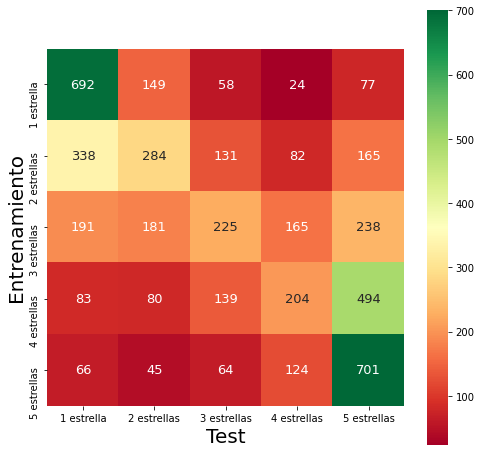

Modelo: Random Forest


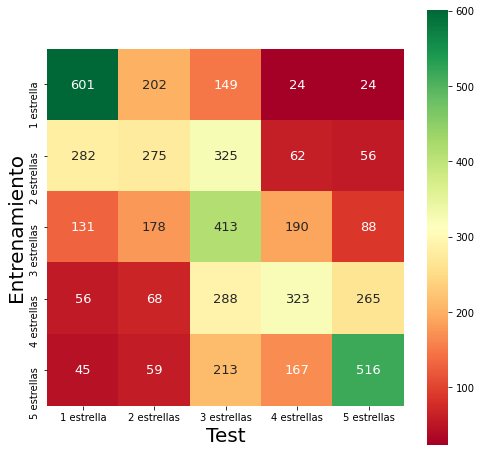

Modelo: SVC


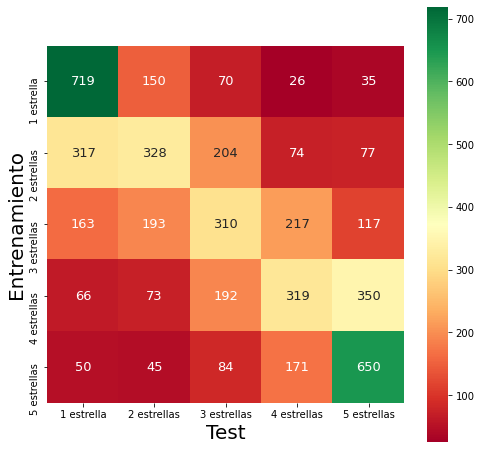

In [150]:
lista_modelos = ([y_test_pred,'Naive-Bayes'],[y_test_pred_rf,'Random Forest'],[y_test_pred_svc,'SVC'])

for i in range(0,3):
    print('Modelo: '+lista_modelos[i][1])
    calificacion=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
    cm = confusion_matrix(y_test,lista_modelos[i][0])
    f,ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cm, square = True, annot=True, fmt= '.0f',annot_kws={'size': 13}, cmap= 'RdYlGn',ax=ax)

    plt.xlabel("Test", size =20)
    plt.ylabel("Entrenamiento", size =20)
    ax.set_xticklabels(calificacion)
    ax.set_yticklabels(calificacion)
    plt.show()

Puedo concluir a partir de estos resultados que <code>Random Forest</code> es el que mejor predice resultados intermedios (**3 estrellas**), mientras que los otros 2 cuentan con mayor precisión en las reseñas con una tendencia más marcada (**1 ó 5 estrellas**). Esto se puede corroborar en las nubes de palabras, donde la mayoría de las palabas utilizadas son comunes para las reseñas entre 2 y 4 estrellas, mientras que en las más extremas presentan palabras particulares, como "malo" o "excelente"

Sin embargo, la precisión es marcadamente mejor en el SVC, además de que en el de Random Forest existe overfitting, por lo que el mejor modelo sigue siendo el de SVC.